In [2]:
# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [3]:
import sys
sys.path.append('../')

# importing all source code
from src.features import build_features
from src.visualization import visualize
from src.data import make_dataset
from src.reports import make_report

import pandas as pd
import numpy as np

In [5]:
## !/usr/bin/env python
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import math

import logging
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import jinja2
import pdfkit

import sys
sys.path.append('../../')

from src.features import build_features
from src.visualization import visualize

class beiwe_participation_report():
    '''

    '''
    def __init__(self,report_date):
        '''

        '''

        self.report_date = report_date
        self.firstDate = datetime(2020,5,13)
        self.maxDailySurveys = np.busday_count(self.firstDate.date(), self.report_date.date(), weekmask='Sun Mon Wed Fri')
        self.maxWeeklySurveys = np.busday_count(self.firstDate.date(), self.report_date.date(), weekmask='Sat')

    def import_survey_summary(self,surveyType='morning'):
        '''
        Imports survey summary csv files, cuts it down to the specified date, and returns a cleaned dataframe
        '''
        
        # importing datafile
        temp = pd.read_csv(f"/Users/hagenfritz/Projects/utx000/data/interim/survey_mood_{surveyType}_summary.csv",index_col=0)
        
        # getting dataframe in date range
        df = pd.DataFrame()
        for column in temp.columns:
            if datetime.strptime(column,'%m/%d/%Y') <= self.report_date:
                df = pd.concat([df,temp[column]],axis=1)
            
        # converting elements to numbers and creating sum/percent column
        for column in df.columns:
            df[column] = pd.to_numeric(df[column],errors='coerce')
            
        df['Sum'] = df.sum(axis=1)
        if surveyType in ['morning','evening']:
            df['Percent'] = df['Sum'] / self.maxDailySurveys
        else:
            df['Percent'] = df['Sum'] / self.maxWeeklySurveys
        
        return df

    def load_survey_data(self):
        '''

        '''

        # importing
        self.morn = self.import_survey_summary('morning')
        self.night = self.import_survey_summary('evening')
        self.week = self.import_survey_summary('week')

    def load_sensor_data(self,dateThru='06082020'):
        '''

        '''
        self.acc = pd.read_csv(f'/Users/hagenfritz/Projects/utx000/data/interim/acc_summary.csv',
                  index_col=0)

    def create_plots(self):
        '''

        '''
        # morning and evening histograms
        fig, axes = plt.subplots(1,2,figsize=(12,6),sharey=True)
        i = 0
        colors = ('firebrick','cornflowerblue')
        for df,name in zip([self.morn,self.night],['morning','evening']):
            ax = axes[i]
            sns.distplot(df['Sum'],bins=np.arange(0,self.maxDailySurveys+5,1),color=colors[i],kde=False,label=name,ax=ax)
            ax.set_xticks(np.arange(0,self.maxDailySurveys+5,1))
            ax.set_xlim([0,self.maxDailySurveys+5])
            ax.set_ylim([0,10])
            ax.set_xlabel('Total Surveys Completed')
            ax.legend(title='Survey Timing')
            i += 1

        axes[0].set_ylabel('Number of Participants')
        axes[0].text(self.maxDailySurveys+1,-1.5,f'Max Possible Surveys: {self.maxDailySurveys}')
        axes[1].set_xticks(np.arange(1,self.maxDailySurveys+5,1))
            
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=None)
        plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/daily_survey_summary_histogram.png')

        # weekly histograms
        fig,ax = plt.subplots(figsize=(12,6))
        sns.distplot(self.week['Sum'],bins=np.arange(0,6,1),kde=False,color='cornflowerblue')
        ax.set_xticks(np.arange(0,6,1))
        ax.set_xlabel(f'Total Surveys Completed - Max Possible: {self.maxWeeklySurveys}')
        ax.set_xlim([0,5])
        ax.set_ylabel('Number of Participants')

        plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/weekly_survey_summary_histrogram.png')

        # participation tier
        for survey,timing in zip([self.morn,self.night],['morning','evening']):
            fig, ax = plt.subplots(figsize=(12,8))
            colors = ['red','orange','yellow','green','blue','violet']
            shapes = ['o', 'v', '^', '<', '>', '8', 's', 'd']
            df = survey.sort_values('Sum')
            per = np.zeros(4)
            for i in range(len(df)):
                ax.scatter(i,df['Sum'][i]/self.maxDailySurveys,color=colors[i%6],edgecolor='black',marker=shapes[math.floor(i/6)],s=100,label=df.index[i])
                if df['Sum'][i]/self.maxDailySurveys < 0.25:
                    per[0] += 1
                elif df['Sum'][i]/self.maxDailySurveys < 0.5:
                    per[1] += 1
                elif df['Sum'][i]/self.maxDailySurveys < 0.75:
                    per[2] += 1
                else:
                    per[3] += 1
            ax.legend(title='Participants',bbox_to_anchor=(1.12,1),ncol=2)
            ax.set_xticklabels([])
            ax.set_yticks([0,0.25,0.5,0.75,1,1.25])
            ax.set_xlim([-1,len(df)+15])
            ax.grid(axis='y')

            for p, spot in zip(per,[0.05,0.3,0.55,0.8]):
                ax.text(len(df),spot,f'n={int(p)}')

            plt.savefig(f'/Users/hagenfritz/Projects/utx000/reports/beiwe_check/{timing}_participation_tier.png')

        # moring and evening time series
        fig,ax = plt.subplots(figsize=(12,6))
        for df,name in zip([self.morn,self.night],['morning','evening']):
            dates = []
            daily = []
            for column in df.columns:
                if column in ['Sum','Percent']:
                    continue
                    
                dates.append(datetime.strptime(column,'%m/%d/%Y'))
                daily.append(np.sum(df[column]))
                
            #ax.stem(dates,daily)
            if name == 'morning':
                plt.vlines(x=dates, ymin=0, ymax=daily, color='orange',alpha=1)
                plt.scatter(dates,daily,s=50, color='orange',edgecolor='black',alpha=1,label='morning')
            else:
                plt.vlines(x=dates, ymin=0, ymax=daily, color='purple',alpha=1)
                plt.scatter(dates,daily,s=100, color='purple',edgecolor='black',alpha=1,label='evening')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
            ax.xaxis.set_major_locator(mdates.DayLocator())
            plt.xticks(rotation=-30,ha='left')
            ax.set_ylabel('Number of Surveys Submitted Daily')
            ax.set_ylim([0,30])
            ax.set_yticks(np.arange(0,31,2))

        ax.grid(axis='y')    
        ax.legend(title='Survey Timing')

        plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/daily_survey_timeseries.png')

        # poor participant time series
        fig, axes = plt.subplots(2,1,figsize=(12,6),sharex=True)
        for survey,ax in zip([self.morn,self.night],axes):
            poorSports = survey[survey['Percent'] <= 0.25]
            for i in range(len(poorSports)):
                ax.plot(np.cumsum(poorSports.iloc[i,:-2]),label=poorSports.index[i])
            
        axes[0].legend(title='Participants',loc='upper left')
        axes[0].set_ylabel('Morning Surveys Completed')
        axes[1].set_ylabel('Evening Surveys Completed')
        plt.subplots_adjust(hspace=0)
        plt.xticks(rotation=-30,ha='left')
        plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/daily_survey_badparticipants_timeseries.png')

        # weekly time series
        fig,ax = plt.subplots(figsize=(12,6))
        df = self.week
        dates = []
        daily = []
        for column in df.columns:
            if column in ['Sum','Percent']:
                continue
            try:
                dates.append(datetime.strptime(column,'%m/%d/%Y'))
            except ValueError:
                print('Wrong format (%m/%d/%Y) - trying %m/%d/%y')
                dates.append(datetime.strptime(column,'%m/%d/%y'))
            daily.append(np.sum(df[column]))

        plt.vlines(x=dates, ymin=0, ymax=daily, color='orange',alpha=1)
        plt.scatter(dates,daily,s=50, color='orange',edgecolor='black',alpha=1,label='morning')
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
        ax.xaxis.set_major_locator(mdates.DayLocator())
        plt.xticks(rotation=-30,ha='left')
        ax.set_ylabel('Number of Surveys Submitted Daily')
        ax.set_ylim([0,30])
        ax.set_yticks(np.arange(0,31,2))

        ax.grid(axis='y')
        plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/weekly_survey_timeseries.png')

        # acc time series
        fig,ax = plt.subplots(figsize=(12,6))
        df = self.acc
        dates = []
        daily = []
        for column in df.columns:
            if column in ['Sum','Percent']:
                continue

            try:
                dates.append(datetime.strptime(column,'%m/%d/%Y'))
            except ValueError:
                print('Wrong format (%m/%d/%Y) - trying %m/%d/%y')
                dates.append(datetime.strptime(column,'%m/%d/%y'))
            daily.append(np.sum(df[column]))

        try:
            plt.vlines(x=dates, ymin=0, ymax=daily, color='orange',alpha=1)
            plt.scatter(dates,daily,s=50, color='orange',edgecolor='black',alpha=1,label='morning')
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%a %m/%d'))
            ax.xaxis.set_major_locator(mdates.DayLocator())
            plt.xticks(rotation=-30,ha='left')
            ax.set_xlim([datetime(2020,4,24),datetime(2020,5,31)])
            ax.set_ylim([0,1750000])
            ax.set_ylabel('Number of Daily Bytes')

            plt.savefig('/Users/hagenfritz/Projects/utx000/reports/beiwe_check/acc_timeseries.png')
        except:
            print('Could not generate accelerometer plot - try changing the data from \'general\' to \'number\' in Excel')

    def get_filename(self,filename):

        return f'/Users/hagenfritz/Projects/utx000/reports/beiwe_check/{filename}.png'

    def generate_report(self):
        '''

        '''

        templateLoader = jinja2.FileSystemLoader(searchpath="/Users/hagenfritz/Projects/utx000/reports/templates/")
        templateEnv = jinja2.Environment(loader=templateLoader)
        templateEnv.globals['get_filename'] = self.get_filename
        TEMPLATE_FILE = "beiwe_participation_template.html"
        template = templateEnv.get_template(TEMPLATE_FILE)
        outputText = template.render(date=self.report_date.date())
        
        # html file output
        html_file = open(f'/Users/hagenfritz/Projects/utx000/reports/beiwe_check/report_{self.report_date.date()}.html', 'w')
        html_file.write(outputText)
        html_file.close()

        # pdf file output
        pdfkit.from_file(f'/Users/hagenfritz/Projects/utx000/reports/beiwe_check/report_{self.report_date.date()}.html',
            f'/Users/hagenfritz/Projects/utx000/reports/beiwe_check/report_{self.report_date.date()}.pdf')

    def generate_report_from_interim(self):
        '''

        '''
        self.load_survey_data()
        self.load_sensor_data()
        self.create_plots()
        self.generate_report()

class iaq_beacon_study_report():
    '''

    '''

    def __init__(self, study, study_start, study_end):
        '''
        Imports the raw data from the IAQ Beacon

        Parameters
        - study: string holding the study name which helps find the correct processed file
        - study_start: datetime corresponding to the start of the study
        - study_end: datetime corresponding to the end of the study
        '''

        # parameters
        self.study = study
        self.study_start = study_start
        self.study_end = study_end

    def load_data(self):
        '''
        Loads in the data from the processed data dir if the data file exists

        Returns True if the data file was correctly processed
        '''
        print('\tImporting data...')
        try:
            self.data = pd.read_csv(f'../../data/processed/{self.study}-beacon.csv',index_col='Timestamp',parse_dates=True)
        except Exception as inst:
            print(f'\t{inst}')
            print('\tUnable to process data file - check study name or run make_dataset script')
            return False

        # importing user-created functions
        self.beacon_stats = build_features.beacon_statistics()
        self.plotter = visualize.single_var(self.study)

        return True

    def create_plots(self):
        '''
        Creates the plots that will be added to the reports
        '''
        # Getting just the sensors (all columns but the last one)
        sensors = self.data.columns[:-1]

        # time series
        print('\tCreating figures...')
        # TVOC,eCO2,Lux,Visible,Infrared,NO2,T_NO2,RH_NO2,CO,T_CO,RH_CO,Temperature [C],Relative Humidity,CO2,PM_N_0p5,PM_N_1,PM_N_2p5,PM_N_4,PM_N_10,PM_C_1,PM_C_2p5,PM_C_4,PM_C_10
        thresholds = [100,2000,10000,0,50,100,26,50,35000,26,50,26,50,2000,0,0,0,0,5,12,24,35]
        for sensor, threshold in zip(sensors,thresholds):
            t_neg = self.beacon_stats.get_measurement_time(self.data,self.study_start,self.study_end,sensor=sensor)
            t_threshold = self.beacon_stats.get_measurement_time(self.data,self.study_start,self.study_end,sensor=sensor,threshold=threshold,below=False)
            for beacon_no in self.data['Beacon'].unique():
                # getting data for beacon between study period 
                data_by_beacon = self.data[self.data['Beacon'] == beacon_no]
                data_by_beacon = data_by_beacon[self.study_start:self.study_end]
                # plotting and saving
                if len(data_by_beacon) < 3 or np.nanmean(data_by_beacon[sensor]) < -50:
                    fig, ax = self.plotter.timeseries([self.study_start,self.study_end],[0,0],figsize=(12,6),label='Percent Completion',ylim=[-0.1,1.1],yticks=np.arange(0,1.1,1))
                else:
                    fig, ax = self.plotter.timeseries(data_by_beacon.index,data_by_beacon[sensor],figsize=(12,6),label='Measured Values in Relevant Units')
                    ax.set_title(f'Time Negative: {t_neg[beacon_no]}, Time Above {threshold}: {t_threshold[beacon_no]} minutes')

                plt.savefig(f'../../reports/figures/{self.study}-beacon{beacon_no}-{sensor}-timeseries.png')
                plt.close()

        # reliability figure
        for sensor in sensors:
            agg_complete, hour_complete = self.beacon_stats.get_percent_completeness(self.data,self.study_start,self.study_end,sensor=sensor)
            for key in hour_complete.keys():
                # beacon_no == key
                if len(hour_complete[key].index) < 3:
                    fig, ax = self.plotter.timeseries([self.study_start,self.study_end],[0,0],figsize=(12,6),label='Percent Completion',ylim=[-0.1,1.1],yticks=np.arange(0,1.1,1))
                else:
                    # Inserting extra timestamps at +1 hours every other location
                    dt = [x for y in zip(hour_complete[key].index,hour_complete[key].index+timedelta(hours=1)) for x in y]
                    # Repeating entries to match with doubled indices
                    percent = np.repeat(hour_complete[key][sensor],2)
                    fig, ax = self.plotter.timeseries(dt,percent,figsize=(12,6),label='Percent Completion',ylim=[-0.1,1.1],yticks=np.arange(0,1.1,1))
                    reliability = round(agg_complete[key],2)
                    ax.set_title(f'Overall Reliability: {reliability}')
                    
                plt.savefig(f'../../reports/figures/{self.study}-beacon{key}-{sensor}-reliability.png')
                plt.close()
                
        # heatmap
        for sensor in sensors

    def get_filename(self,beginning,ending):
        '''
        This function is used in the html file to pull in the figures

        Parameters:
        - beginning: list of two values
        '''
        return f'/Users/hagenfritz/Projects/utx000/reports/figures/{beginning[0]}-beacon{beginning[1]}-{ending}.png'

    def generate_report(self):
        '''
        Generates the report by loading the relevant variables/figures in the html file
        '''

        print('\tGenerating report...')
        # generate reports for each beacon
        for beacon_no in self.data['Beacon'].unique():
            templateLoader = jinja2.FileSystemLoader(searchpath="/Users/hagenfritz/Projects/utx000/reports/templates/")
            templateEnv = jinja2.Environment(loader=templateLoader)
            templateEnv.filters['get_filename'] = self.get_filename
            TEMPLATE_FILE = "beacon_study_operation_template.html"
            template = templateEnv.get_template(TEMPLATE_FILE)
            outputText = template.render(study=self.study,beacon_no=beacon_no,start_date=self.study_start.date(),end_date=self.study_end.date())
            
            # html file output
            html_file = open(f'/Users/hagenfritz/Projects/utx000/reports/beacon_check/beacon{beacon_no}_{self.study_start.date()}-{self.study_end.date()}.html', 'w')
            html_file.write(outputText)
            html_file.close()

            # pdf file output
            pdfkit.from_file(f'/Users/hagenfritz/Projects/utx000/reports/beacon_check/beacon{beacon_no}_{self.study_start.date()}-{self.study_end.date()}.html',
                f'/Users/hagenfritz/Projects/utx000/reports/beacon_check/beacon{beacon_no}_{self.study_start.date()}-{self.study_end.date()}.pdf')

    def generate_report_from_processed(self):
        '''
        Generates the report from the processed data
        '''
        data_was_loaded = self.load_data()
        if data_was_loaded:
            self.create_plots()
            self.generate_report()
        else:
            print('No report generated')

def main():
    '''
    Generates reports
    '''
    logger = logging.getLogger(__name__)

    # Control 
    print('Generate Report ToC')
    print('\t1. Beiwe Participation Check')
    print('\t2. IAQ Beacon Study Report')
    ans = int(input('Number choice: '))

    # Generate Biewe Check Report
    if ans == 1:
        logger.info('Generating Beiwe Participation Check Report...')
        dateThru = input('Date Thru for Beiwe Participation Check (%m%d%Y): ')
        report_gen = beiwe_participation_report(datetime.strptime(dateThru,'%m%d%Y'))
        report_gen.generate_report_from_interim()
        logger.info('Generated')
    if ans == 2:
        logger.info('Generating IAQ Beacon Study Report...')
        study_name = input('Name of Study: ')
        study_start = input('Date Start for Study Check (%m%d%Y): ')
        study_end = input('Date Start for Study Check (%m%d%Y): ')
        report_gen = iaq_beacon_study_report(study_name,datetime.strptime(study_start,'%m%d%Y'),datetime.strptime(study_end,'%m%d%Y'))
        report_gen.generate_report_from_processed()
        logger.info('Generated')
    else:
        print('\nInvalid choice - please try running again')

In [10]:
data = pd.read_csv('../data/processed/bpeace2-beacon.csv',index_col='Timestamp',parse_dates=True)

In [8]:
plotter = visualize.single_var('bpeace2')

In [16]:
600/10000

0.06

(<Figure size 1152x864 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f8ca4d0c828>)

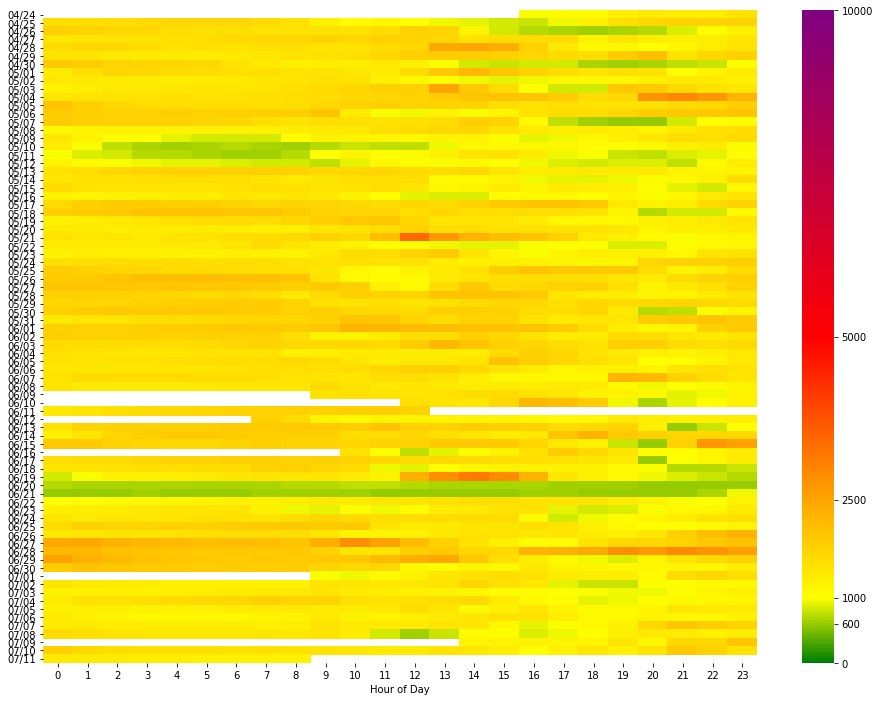

In [19]:
data_by_beacon = data[data['Beacon'] == 7]
plotter.heatmap(data_by_beacon,'CO2',figsize=(16,12),colorbar={'colors':['green','yellow','orange','red','purple'],
                                                               'ratios':[0,0.1,0.25,.5,1],
                                                               'ticks':[0,600,1000,2500,5000,10000]})